# Steps Labeling
We now label the ski steps using the model we build. Our model classifies each datapoint as either a step (within a step) or a non-step. Now we need to group them neighboring "step" datapoints together to form actual steps.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np
from numpy import mean
from numpy import std

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import joblib

from src.data.labels_util import load_labels, LabelCol, get_labels_file, load_clean_labels, get_workouts
from src.data.imu_util import (
    get_sensor_file, ImuCol, load_imu_data, Sensor, fix_epoch, resample_uniformly, time_to_row_range, get_data_chunk,
    normalize_with_bounds, data_to_features, list_imu_abspaths, clean_imu_data, BOOT_CUTOFF, POLE_CUTOFF
)
from src.data.util import find_nearest, find_nearest_index, shift, low_pass_filter, add_col
from src.data.workout import Activity, Workout
from src.data.data import DataState
from src.data.build_features import main as build_features
from src.data.features_util import list_test_files
from src.model.train import evaluate_model_accuracy, train_model, create_xgboost
from src.model.predict import (
    evaluate_on_test_data, evaluate_on_test_data_plot, evaluate_step_labeling_on_test, 
    display_step_labeling_result_on_test, label_steps_for_features
)
from src.visualization.visualize import multiplot
from src.config import (
    TRAIN_BOOT_DIR, TRAIN_POLE_DIR, TRAIN_FEATURES_FILENAME, TRAIN_LABELS_FILENAME, BOOT_MODEL_FILE, 
    POLE_MODEL_FILE, DATA_DIR
)

# import data types
from pandas import DataFrame
from numpy import ndarray
from typing import List, Tuple, Optional
from pathlib import Path

## Test data
Perform steps labeling on test data

### Step labeling results

Boot:


<IPython.core.display.Javascript object>


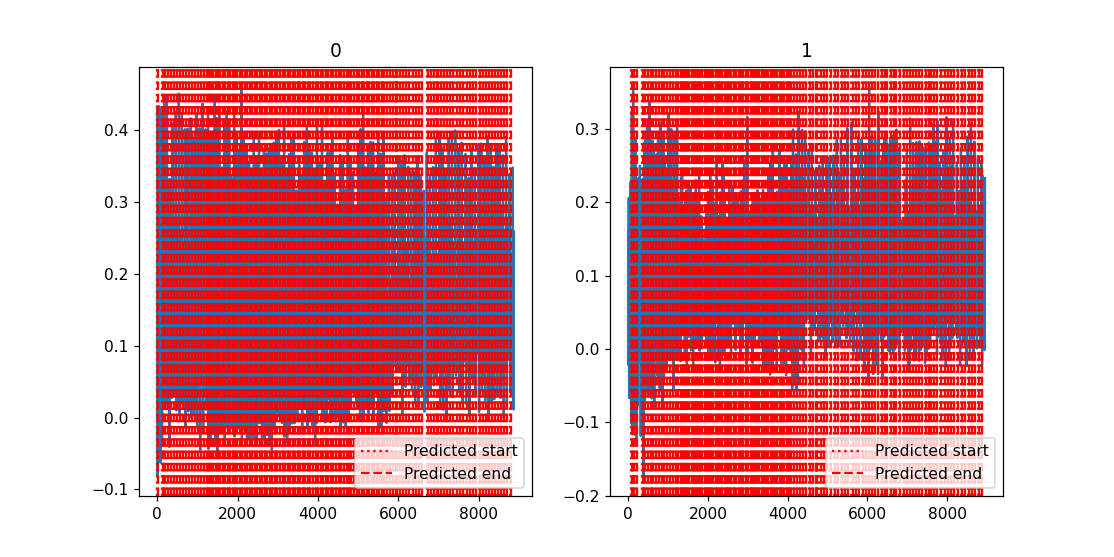

In [2]:
print('Boot:')
plt.rcParams['figure.figsize'] = [10, 5]
display_step_labeling_result_on_test(Activity.Boot)

Pole:


<IPython.core.display.Javascript object>


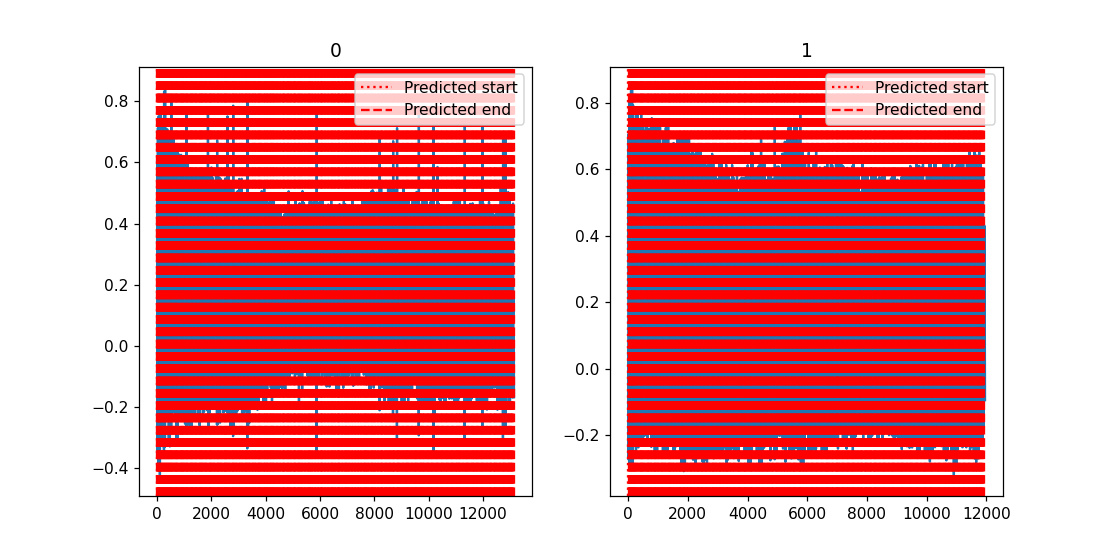

In [3]:
print('Pole:')
plt.rcParams['figure.figsize'] = [10, 5]
display_step_labeling_result_on_test(Activity.Pole)

### Evaluation

Boot


<IPython.core.display.Javascript object>


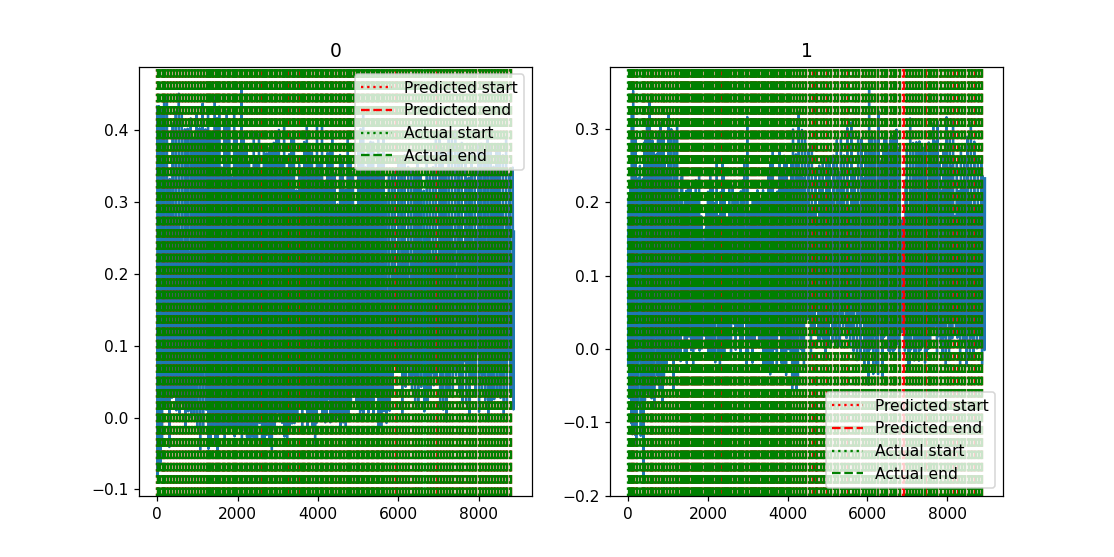

Test 0
Total steps: 129
Total steps predicted: 129
Accurate to within 0 datapoint:
- Start: 0.558140
- End: 0.596899
Accurate to within 1 datapoint:
- Start: 0.945736
- End: 0.922481
Accurate to within 2 datapoint:
- Start: 0.976744
- End: 0.945736
Accurate to within 3 datapoint:
- Start: 0.976744
- End: 0.945736
Accurate to within 4 datapoint:
- Start: 0.976744
- End: 0.945736

Test 1
Total steps: 127
Total steps predicted: 126
Accurate to within 0 datapoint:
- Start: 0.669291
- End: 0.645669
Accurate to within 1 datapoint:
- Start: 0.976378
- End: 0.913386
Accurate to within 2 datapoint:
- Start: 0.976378
- End: 0.913386
Accurate to within 3 datapoint:
- Start: 0.976378
- End: 0.913386
Accurate to within 4 datapoint:
- Start: 0.976378
- End: 0.913386



In [4]:
print('Boot')
plt.rcParams['figure.figsize'] = [10, 5]
evaluate_step_labeling_on_test(Activity.Boot)

Pole


<IPython.core.display.Javascript object>


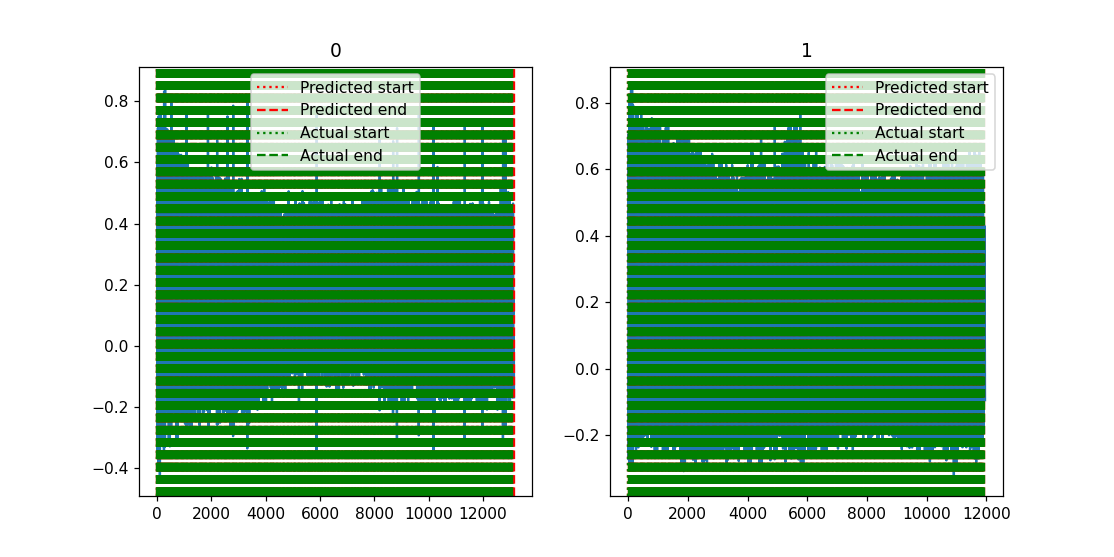

Test 0
Total steps: 284
Total steps predicted: 285
Accurate to within 0 datapoint:
- Start: 0.721831
- End: 0.644366
Accurate to within 1 datapoint:
- Start: 0.996479
- End: 0.985915
Accurate to within 2 datapoint:
- Start: 1.000000
- End: 0.992958
Accurate to within 3 datapoint:
- Start: 1.000000
- End: 0.992958
Accurate to within 4 datapoint:
- Start: 1.000000
- End: 0.992958

Test 1
Total steps: 292
Total steps predicted: 292
Accurate to within 0 datapoint:
- Start: 0.715753
- End: 0.664384
Accurate to within 1 datapoint:
- Start: 1.000000
- End: 0.989726
Accurate to within 2 datapoint:
- Start: 1.000000
- End: 1.000000
Accurate to within 3 datapoint:
- Start: 1.000000
- End: 1.000000
Accurate to within 4 datapoint:
- Start: 1.000000
- End: 1.000000



In [5]:
print('Pole')
plt.rcParams['figure.figsize'] = [10, 5]
evaluate_step_labeling_on_test(Activity.Pole)

## Custom Test

### Load data

<IPython.core.display.Javascript object>


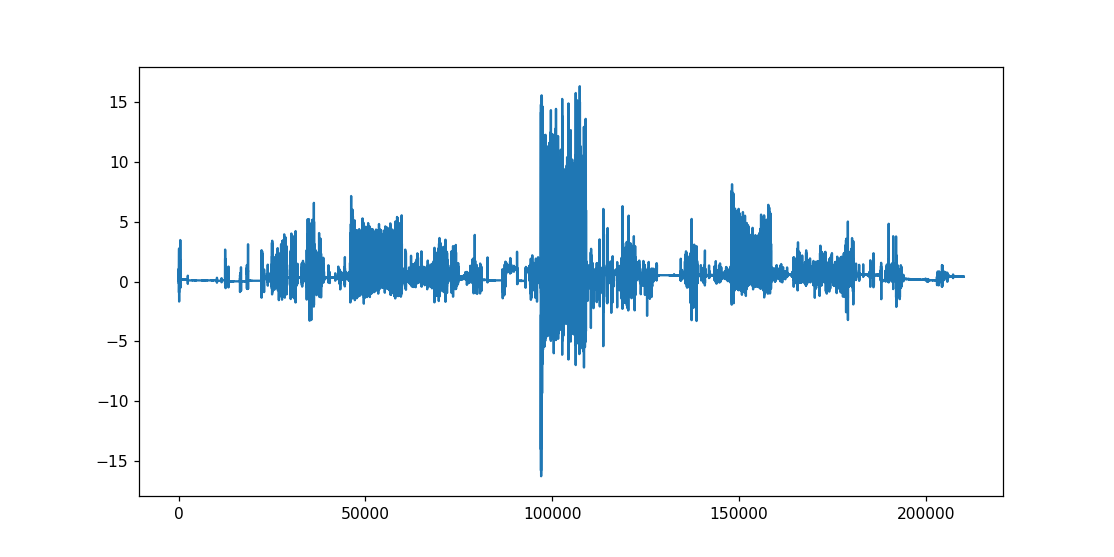

In [6]:
# Load and clean
file = DATA_DIR / 'test_7L.csv' # SELECT FILE
imu_data: ndarray = load_imu_data(file)
imu_data = clean_imu_data(imu_data)

# Select workouts
def plot_helper(idx, plot):
    plot.plot(imu_data[:, ImuCol.XACCEL])
multiplot(1, plot_helper)

### Select workouts

<IPython.core.display.Javascript object>


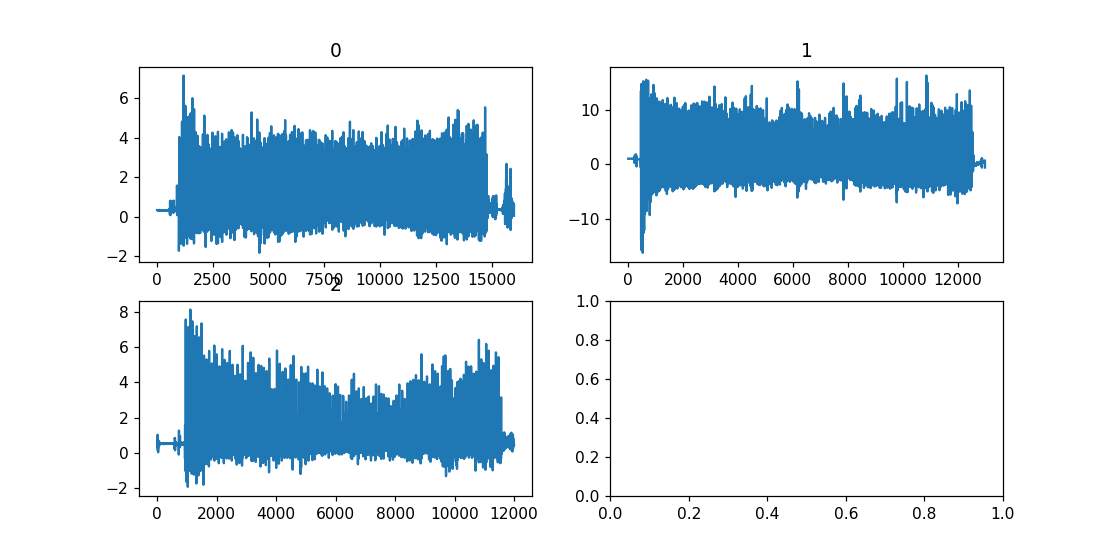

In [7]:
# SELECT WORKOUTS
workouts: List[Tuple[int, int]] = [(45000, 61000), (96500, 109500), (147000, 159000)]
workouts_activity: List[Activity] = [Activity.Boot, Activity.Pole, Activity.Boot]

# Confirm workouts
def plot_helper(idx, plot):
    start, end = workouts[idx]
    plot.plot(imu_data[start:end+1, ImuCol.XACCEL])
    plot.title.set_text(str(idx))
multiplot(len(workouts), plot_helper)

### Labeled steps

<IPython.core.display.Javascript object>


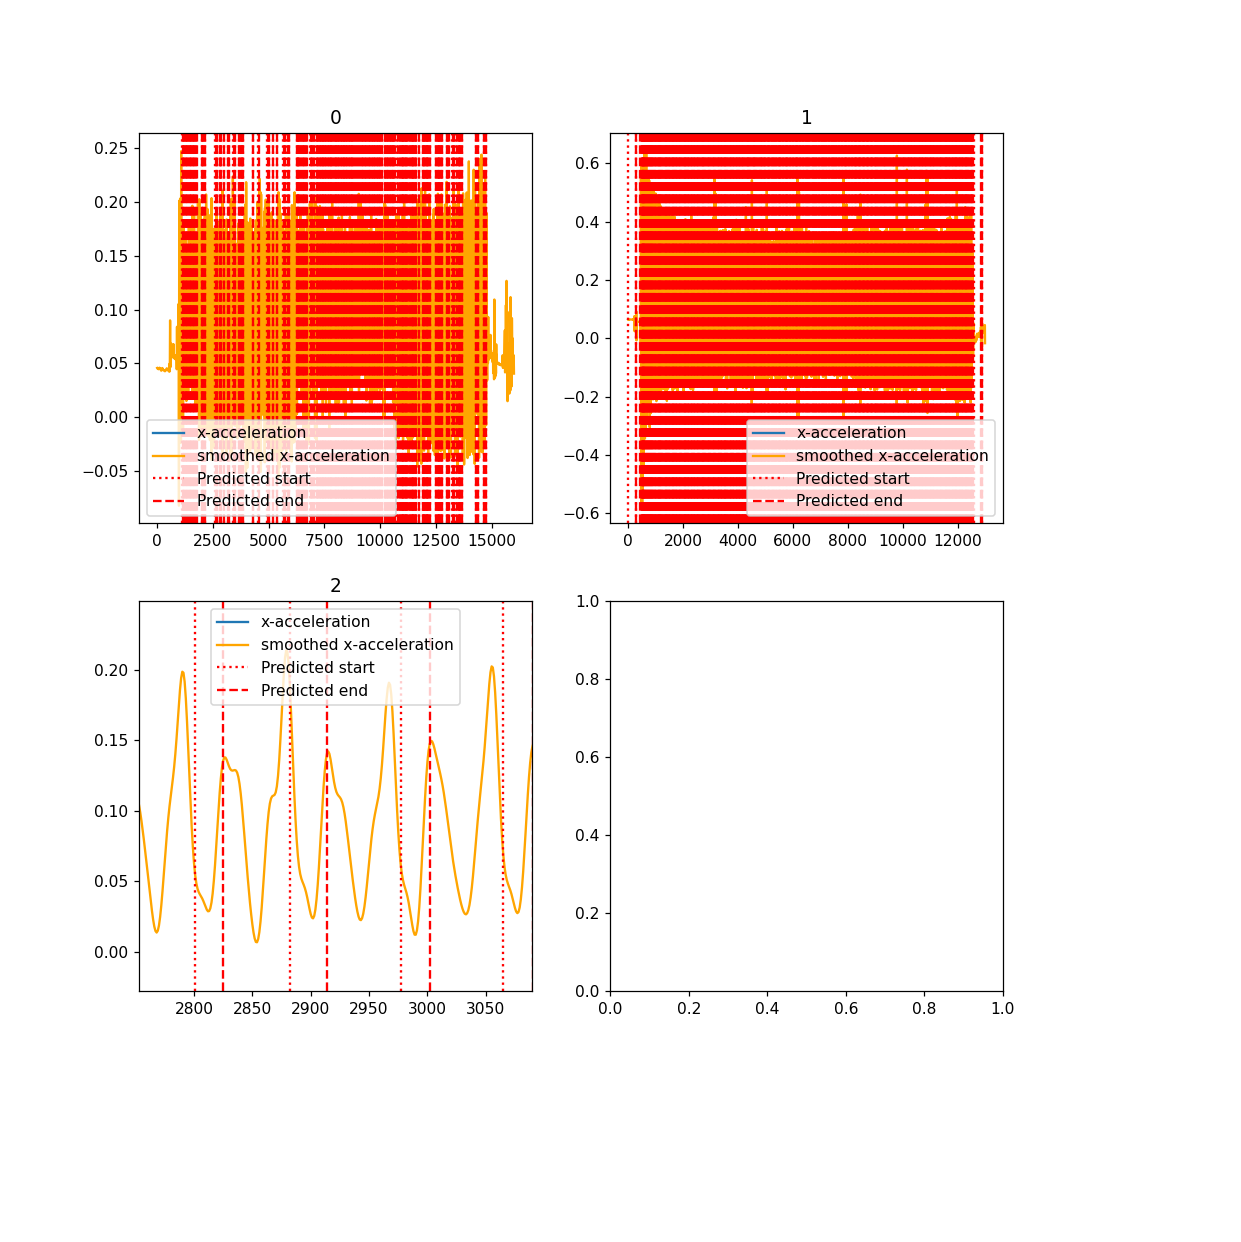

In [8]:
def plot_helper(idx, plot):
    start, end = workouts[idx]
    activity = workouts_activity[idx]
        
    # Plot IMU data
    #plot.plot(imu_data[start:end+1, ImuCol.XACCEL])
    
    # Plot smoothed IMU data
    features: ndarray = data_to_features(imu_data, start, end, activity)
    features = features[start:end+1,]
    cutoff = BOOT_CUTOFF if activity == Activity.Boot else POLE_CUTOFF
    # [option] depending if "data_to_feature" uses a low-pass filter
    plot.plot(low_pass_filter(features[:, 0], cutoff=cutoff), color='orange')
    #plot.plot(features[:, 0], color='orange')
    
    # Plot labels
    steps: List[Tuple[int, int]] = label_steps_for_features(features, activity)
    for start, end in steps:
        plot.axvline(x=start, color='red', linestyle='dotted')
        plot.axvline(x=end, color='red', linestyle='dashed')
        
    # Legend
    legend_items = [Line2D([], [], label='x-acceleration'),
                Line2D([], [], color='orange', label='smoothed x-acceleration'),
                Line2D([], [], color='red', linestyle='dotted', label='Predicted start'), 
                Line2D([], [], color='red', linestyle='dashed', label='Predicted end')]
    plot.legend(handles=legend_items)
    
    plot.title.set_text(str(idx))

plt.rcParams['figure.figsize'] = [10, 10]
multiplot(len(workouts), plot_helper)